In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

base_path = "/content/drive/MyDrive/IRMAS-TrainingData"
classes = os.listdir(base_path)
print("Classes found:", classes)

Classes found: ['tru', 'sax', 'flu', 'cla', 'X_mel.npy', 'X_mfcc.npy', 'X_chroma.npy', 'y_labels.npy']


In [5]:
!pip install librosa
!pip install soundfile

In [ ]:
#load and normalize audio

In [6]:
import os
import librosa
import numpy as np

In [7]:
# Set path to your structured dataset
DATA_PATH = '/content/drive/MyDrive/IRMAS-TrainingData'

# List of instrument folders to include
instrument_labels = ['cla', 'flu', 'sax', 'tru']

#parameters for audio processing and normalization
SAMPLE_RATE = 22050
DURATION = 5  # seconds to standardize audio length
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def load_audio_files(data_path, instruments, duration=5):
    X = []  # features
    y = []  # labels

    for label in instruments:
        folder = os.path.join(data_path, label)
        for file in os.listdir(folder):
            if file.endswith('.wav'):
                file_path = os.path.join(folder, file)
                # Load and normalize
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)
                signal = signal / np.max(np.abs(signal))  # Normalize to [-1, 1]

                if len(signal) < SAMPLES_PER_TRACK:
                    # Pad if shorter
                    signal = np.pad(signal, (0, SAMPLES_PER_TRACK - len(signal)))
                else:
                    # Truncate if longer
                    signal = signal[:SAMPLES_PER_TRACK]

                X.append(signal)
                y.append(label)

    return np.array(X), np.array(y)

# Load normalized audio data and labels
X_audio, y_labels = load_audio_files(DATA_PATH, instrument_labels)

print(f"Loaded {len(X_audio)} audio samples.")

#np.save('../data/X_audio.npy', np.array(X_audio, dtype=object))
#np.save('../data/y_labels.npy', np.array(y_labels))

Loaded 2159 audio samples.


In [ ]:
#feature preparation

In [8]:
import librosa
import numpy as np

In [9]:
# Parameters
sr = 22050
n_mfcc = 13
n_mels = 128

# Storage lists
X_mel, X_mfcc, X_chroma = [], [], []

for i, signal in enumerate(X_audio):
    # Mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)

    # MFCCs
    mfcc = librosa.feature.mfcc(S=mel_db, sr=sr, n_mfcc=n_mfcc)

    # Chroma
    chroma = librosa.feature.chroma_stft(y=signal, sr=sr)

    # Store features
    X_mel.append(mel_db)
    X_mfcc.append(mfcc)
    X_chroma.append(chroma)

    if i % 20 == 0:
        print(f"Processed {i+1}/{len(X_audio)}")

# Convert lists to numpy arrays
X_mel = np.array(X_mel, dtype=object)
X_mfcc = np.array(X_mfcc, dtype=object)
X_chroma = np.array(X_chroma, dtype=object)



Processed 1/2159
Processed 21/2159
Processed 41/2159
Processed 61/2159
Processed 81/2159
Processed 101/2159
Processed 121/2159
Processed 141/2159
Processed 161/2159
Processed 181/2159
Processed 201/2159
Processed 221/2159
Processed 241/2159
Processed 261/2159
Processed 281/2159
Processed 301/2159
Processed 321/2159
Processed 341/2159
Processed 361/2159
Processed 381/2159
Processed 401/2159
Processed 421/2159
Processed 441/2159
Processed 461/2159
Processed 481/2159
Processed 501/2159
Processed 521/2159
Processed 541/2159
Processed 561/2159
Processed 581/2159
Processed 601/2159
Processed 621/2159
Processed 641/2159
Processed 661/2159
Processed 681/2159
Processed 701/2159
Processed 721/2159
Processed 741/2159
Processed 761/2159
Processed 781/2159
Processed 801/2159
Processed 821/2159
Processed 841/2159
Processed 861/2159
Processed 881/2159
Processed 901/2159
Processed 921/2159
Processed 941/2159
Processed 961/2159
Processed 981/2159
Processed 1001/2159
Processed 1021/2159
Processed 1041/2

In [ ]:
np.save('/content/drive/MyDrive/IRMAS-TrainingData/X_mel.npy', X_mel)
np.save('/content/drive/MyDrive/IRMAS-TrainingData/X_mfcc.npy', X_mfcc)
np.save('/content/drive/MyDrive/IRMAS-TrainingData/X_chroma.npy', X_chroma)
np.save('/content/drive/MyDrive/IRMAS-TrainingData/y_labels.npy', y_labels)

In [10]:
print("Loaded shapes:")
print("Mel:", X_mel.shape)
print("MFCC:", X_mfcc.shape)
print("Chroma:", X_chroma.shape)
print("Labels:", len(y_labels))

Loaded shapes:
Mel: (2159, 128, 216)
MFCC: (2159, 13, 216)
Chroma: (2159, 12, 216)
Labels: 2159


In [ ]:
#resize feature for model input

In [12]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [11]:
def resize_features(feature_list, target_shape):
    resize = []
    for f in feature_list:
        h, w = f.shape
        th, tw = target_shape
        f = np.pad(f, ((0, max(th - h, 0)), (0, max(tw - w, 0))), mode='constant')
        f = f[:th, :tw]
        resize.append(f)
    return np.array(resize)

In [13]:
#apply to all features

X_mel_padded = resize_features(X_mel, (128, 216))
X_mel_padded = X_mel_padded[..., np.newaxis]

X_mfcc_padded = resize_features(X_mfcc, (13, 216))
X_mfcc_padded = X_mfcc_padded[..., np.newaxis]   # Shape: (samples, 216, 13)

X_chroma_padded = resize_features(X_chroma, (12, 216))
X_chroma_padded = X_chroma_padded[..., np.newaxis]

In [14]:
#encoding labels

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)
y_categorical = to_categorical(y_encoded)

In [15]:
# data splitting
from sklearn.model_selection import train_test_split

# First, split the labels only
y_train, y_val = train_test_split(
    y_categorical, test_size=0.2, stratify=y_encoded, random_state=42
)

# Now split the features using the same stratify base
X_train_mel, X_val_mel = train_test_split(X_mel_padded, test_size=0.2, stratify=y_encoded, random_state=42)
X_train_mfcc, X_val_mfcc = train_test_split(X_mfcc_padded, test_size=0.2, stratify=y_encoded, random_state=42)
X_train_chroma, X_val_chroma = train_test_split(X_chroma_padded, test_size=0.2, stratify=y_encoded, random_state=42)

print("Shapes:")
print("Mel:", X_train_mel.shape, X_val_mel.shape)
print("MFCC:", X_train_mfcc.shape, X_val_mfcc.shape)
print("Chroma:", X_train_chroma.shape, X_val_chroma.shape)
print("Labels:", y_train.shape, y_val.shape)

Shapes:
Mel: (1727, 128, 216, 1) (432, 128, 216, 1)
MFCC: (1727, 13, 216, 1) (432, 13, 216, 1)
Chroma: (1727, 12, 216, 1) (432, 12, 216, 1)
Labels: (1727, 4) (432, 4)


In [ ]:
#Construction and Training CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout
#note added padding for cnn-mfcc

def build_cnn_model(input_shape, num_classes=4):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(1, 2)),  # works for MFCC and mel with 216 frames

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(1, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(1, 2)),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

In [ ]:
#Model summary
cnn_model = build_cnn_model(input_shape=(12, 216, 1), num_classes=4)
cnn_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 12, 216, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 12, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 12, 108, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 12, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 12, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 12, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │     2,654,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,747,204 (10.48 MB)

 Trainable params: 2,747,204 (10.48 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
#add class weights

from sklearn.utils import class_weight
import numpy as np

y_integers = np.argmax(y_train, axis=1)  # convert one-hot to int labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)

class_weights = dict(enumerate(class_weights))

print(class_weights)

{0: np.float64(1.068688118811881), 1: np.float64(1.195983379501385), 2: np.float64(0.8617764471057884), 3: np.float64(0.9365509761388287)}


In [ ]:
#CNN train

X_train_mel = X_train_mel.astype('float32')
X_val_mel = X_val_mel.astype('float32')
X_train_mfcc = X_train_mfcc.astype('float32')
X_val_mfcc = X_val_mfcc.astype('float32')
X_val_chroma = X_val_chroma.astype('float32')
X_val_chroma = X_val_chroma.astype('float32')
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = cnn_model.fit(
    X_train_chroma, y_train,
    validation_data=(X_val_chroma, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights
)

ValueError: Invalid dtype: object

In [ ]:
# Save model to HDF5 format
cnn_model.save("cnn_mfcc_model.h5")

from google.colab import files
files.download("cnn_mfcc_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

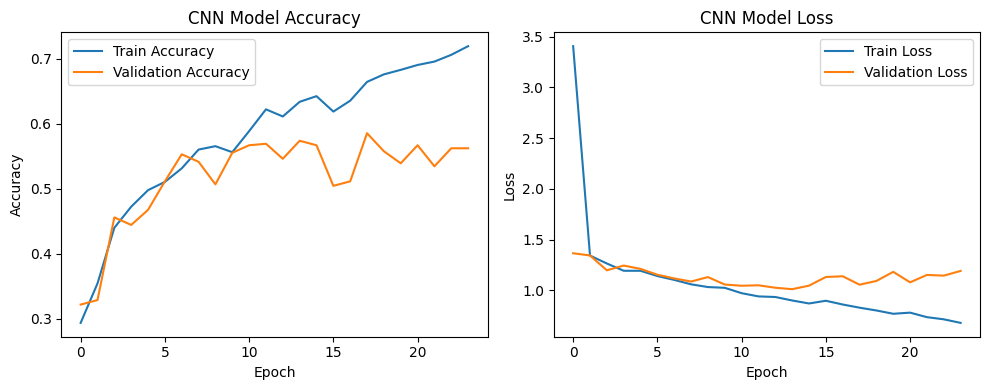

In [ ]:
#model evaluation

import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
🎯 Validation Accuracy: 57.41%
🔍 Precision (Macro): 0.57
🔁 Recall (Macro): 0.57
🧠 F1 Score (Macro): 0.57

📋 Classification Report:
              precision    recall  f1-score   support

         cla       0.52      0.38      0.44       101
         flu       0.57      0.63      0.60        90
         sax       0.59      0.58      0.59       125
         tru       0.59      0.69      0.64       116

    accuracy                           0.57       432
   macro avg       0.57      0.57      0.57       432
weighted avg       0.57      0.57      0.57       432



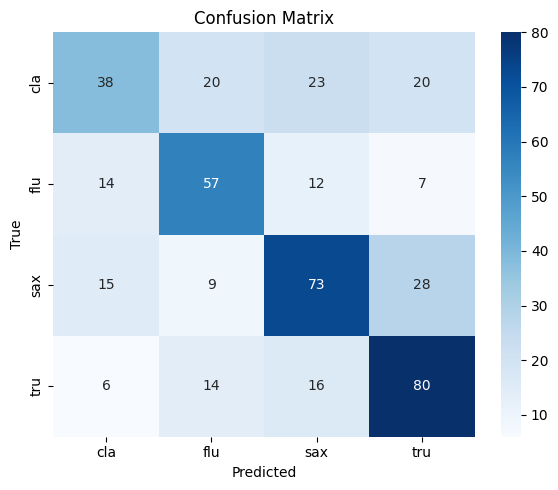

In [ ]:
#evaluate cnn model

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict class probabilities
y_pred_probs = cnn_model.predict(X_val_mel)

# Convert one-hot to class indices
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Print metrics
print("🎯 Validation Accuracy: {:.2f}%".format(accuracy * 100))
print("🔍 Precision (Macro): {:.2f}".format(precision))
print("🔁 Recall (Macro): {:.2f}".format(recall))
print("🧠 F1 Score (Macro): {:.2f}".format(f1))

# Detailed class report
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()



In [26]:
# RNN model
input_shape = (13, 216)  # (timesteps, features)
num_classes = y_train.shape[1]

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Bidirectional

# Define RNN model
def build_rnn_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(13, 216)))
    model.add(Dropout(0.3))

    model.add(LSTM(128))  # Increased units
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

rnn_model = build_rnn_model()
rnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 13, 256)        │       353,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 13, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 558,916 (2.13 MB)

 Trainable params: 558,916 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
print("Shape:", X_train_mfcc.shape)
print("Dtype:", X_train_mfcc.dtype)
print("First item shape:", X_train_mfcc[0].shape)

Shape: (1727, 13, 216, 1)
Dtype: float32
First item shape: (13, 216, 1)


In [29]:
# Step 1: Remove channel dimension (axis -1)
X_train_mfcc = X_train_mfcc.squeeze(-1)     # Result: (1727, 13, 216)
X_val_mfcc = X_val_mfcc.squeeze(-1)

print("X_train_mfcc shape:", X_train_mfcc.shape)
print("X_val_mfcc shape:", X_val_mfcc.shape)

# Step 2: Transpose to (batch, time steps, features) → (1727, 216, 13)
x_train_mfcc = X_train_mfcc.transpose(0, 2, 1)
x_val_mfcc = X_val_mfcc.transpose(0, 2, 1)

print(X_train_mfcc.shape)  # should be (1727, 216, 13)

X_train_mfcc shape: (1727, 13, 216)
X_val_mfcc shape: (432, 13, 216)
(1727, 13, 216)


In [30]:
print("x_train_mfcc shape:", x_train_mfcc.shape)
print("x_train_mfcc dtype:", x_train_mfcc.dtype)
print("x_train_mfcc type:", type(x_train_mfcc))

print("Contains object type?", any(isinstance(x, object) for x in x_train_mfcc.flatten()))

x_train_mfcc shape: (1727, 216, 13)
x_train_mfcc dtype: float32
x_train_mfcc type: <class 'numpy.ndarray'>
Contains object type? True


In [31]:
# Full rebuild with inner shape validation
cleaned_train = []
for i, sample in enumerate(x_train_mfcc):
    try:
        arr = np.asarray(sample, dtype=np.float32)
        if arr.shape != (13, 216):
            raise ValueError(f"Invalid shape at index {i}: {arr.shape}")
        cleaned_train.append(arr)
    except Exception as e:
        print(f"Skipping corrupted sample {i}: {e}")

x_train_mfcc = np.array(cleaned_train, dtype=np.float32)

# Do the same for validation set
cleaned_val = []
for i, sample in enumerate(x_val_mfcc):
    try:
        arr = np.asarray(sample, dtype=np.float32)
        if arr.shape != (13, 216):
            raise ValueError(f"Invalid shape at index {i}: {arr.shape}")
        cleaned_val.append(arr)
    except Exception as e:
        print(f"Skipping corrupted val sample {i}: {e}")

x_val_mfcc = np.array(cleaned_val, dtype=np.float32)




print("Final shape:", x_train_mfcc.shape)
print("Object check:", any(isinstance(x, object) for x in x_train_mfcc.flatten()))

Skipping corrupted sample 0: Invalid shape at index 0: (216, 13)
Skipping corrupted sample 1: Invalid shape at index 1: (216, 13)
Skipping corrupted sample 2: Invalid shape at index 2: (216, 13)
Skipping corrupted sample 3: Invalid shape at index 3: (216, 13)
Skipping corrupted sample 4: Invalid shape at index 4: (216, 13)
Skipping corrupted sample 5: Invalid shape at index 5: (216, 13)
Skipping corrupted sample 6: Invalid shape at index 6: (216, 13)
Skipping corrupted sample 7: Invalid shape at index 7: (216, 13)
Skipping corrupted sample 8: Invalid shape at index 8: (216, 13)
Skipping corrupted sample 9: Invalid shape at index 9: (216, 13)
Skipping corrupted sample 10: Invalid shape at index 10: (216, 13)
Skipping corrupted sample 11: Invalid shape at index 11: (216, 13)
Skipping corrupted sample 12: Invalid shape at index 12: (216, 13)
Skipping corrupted sample 13: Invalid shape at index 13: (216, 13)
Skipping corrupted sample 14: Invalid shape at index 14: (216, 13)
Skipping corrup

In [32]:
# Deep flatten and rebuild the dataset using raw float32 conversion
x_train_mfcc = np.empty((len(cleaned_train), 13, 216), dtype=np.float32)
for i, sample in enumerate(cleaned_train):
    x_train_mfcc[i] = np.array(sample, dtype=np.float32)

x_val_mfcc = np.empty((len(cleaned_val), 13, 216), dtype=np.float32)
for i, sample in enumerate(cleaned_val):
    x_val_mfcc[i] = np.array(sample, dtype=np.float32)

print("Final shape:", x_train_mfcc.shape)
print("Object check:", any(isinstance(x, object) for x in x_train_mfcc.flatten()))

print("Array dtype:", x_train_mfcc.dtype)
print("Array ndim:", x_train_mfcc.ndim)
print("Any object dtype in structure?", x_train_mfcc.dtype == 'object')

Final shape: (0, 13, 216)
Object check: False
Array dtype: float32
Array ndim: 3
Any object dtype in structure? False


In [35]:
#redo trai ntest split of mfcc
x_train_mfcc, x_val_mfcc = train_test_split(X_mfcc_padded, test_size=0.2, stratify=y_encoded, random_state=42)
print("Train shape:", x_train_mfcc.shape)
print("Val shape:", x_val_mfcc.shape)
print("Max train value:", np.max(np.abs(x_train_mfcc)))
print("Max val value:", np.max(np.abs(x_val_mfcc)))

x_train_mfcc = x_train_mfcc / np.max(np.abs(x_train_mfcc))
x_val_mfcc = x_val_mfcc / np.max(np.abs(x_val_mfcc))

Train shape: (1727, 13, 216, 1)
Val shape: (432, 13, 216, 1)
Max train value: 905.0966796875
Max val value: 905.0966796875


In [36]:
# Flatten all object wrappers and force a 3D float32 array
x_train_mfcc = np.array([np.asarray(x, dtype=np.float32) for x in x_train_mfcc.tolist()])
x_val_mfcc = np.array([np.asarray(x, dtype=np.float32) for x in x_val_mfcc.tolist()])

# Convert labels too
y_train = np.asarray(y_train, dtype=np.float32)
y_val = np.asarray(y_val, dtype=np.float32)

# Sanity check
print("Fixed shape:", x_train_mfcc.shape)
print("Fixed type:", type(x_train_mfcc), x_train_mfcc.dtype)
print("Object type check:", any(isinstance(x, object) for x in x_train_mfcc.flatten()))



Fixed shape: (1727, 13, 216, 1)
Fixed type: <class 'numpy.ndarray'> float32
Object type check: True


In [40]:
#Train RNN
#X_train_mfcc = X_train_mfcc.astype('float32')
#X_val_mfcc = X_val_mfcc.astype('float32')
#y_train = y_train.astype('float32')
#y_val = y_val.astype('float32')

#X_train_mfcc = np.array(X_train_mfcc, dtype=np.float32)
#X_val_mfcc = np.array(X_val_mfcc, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
X_train_mfcc = np.array(X_train_mfcc, dtype=np.float32)
X_val_mfcc = np.array(X_val_mfcc, dtype=np.float32)


from tensorflow.keras.callbacks import EarlyStopping

# Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history = rnn_model.fit(
    x_train_mfcc, y_train,
    validation_data=(x_val_mfcc, y_val),
    epochs=50,
    batch_size=32,
    #callbacks=[early_stop]
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8262 - loss: 0.4538 - val_accuracy: 0.5810 - val_loss: 1.5163
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8180 - loss: 0.4500 - val_accuracy: 0.5625 - val_loss: 1.6954
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8377 - loss: 0.4561 - val_accuracy: 0.5764 - val_loss: 1.6251
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8358 - loss: 0.4260 - val_accuracy: 0.5787 - val_loss: 1.6673
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8692 - loss: 0.3568 - val_accuracy: 0.5741 - val_loss: 1.5379
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8452 - loss: 0.4173 - val_accuracy: 0.5926 - val_loss: 1.7049
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8693 - loss: 0.3455 - val_accuracy: 0.5718 - val_loss: 1.7837
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8750 - loss: 0.3208 - val_accuracy: 0.5718 - v

In [42]:
rnn_model.evaluate(x_val_mfcc, y_val)
rnn_model.save("rnn_mfcc_model4.h5")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5505 - loss: 2.6622


In [43]:
from google.colab import files
files.download("rnn_mfcc_model4.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
📌 Validation Accuracy: 56.02%
🔷 Precision (Macro): 0.56
🔶 Recall (Macro): 0.56
💗 F1 Score (Macro): 0.56

📊 Classification Report:
              precision    recall  f1-score   support

         cla       0.52      0.47      0.49       101
         flu       0.56      0.57      0.56        90
         sax       0.59      0.53      0.56       125
         tru       0.56      0.67      0.61       116

    accuracy                           0.56       432
   macro avg       0.56      0.56      0.56       432
weighted avg       0.56      0.56      0.56       432



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

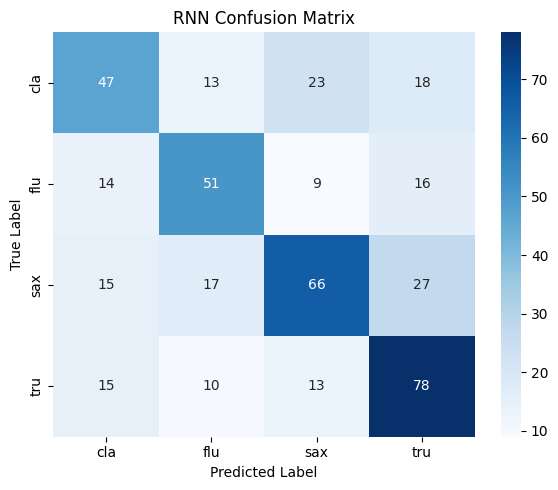

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🔍 Clarinet Confusion Breakdown:
Predicted as cla: 47 times
Predicted as flu: 13 times
Predicted as sax: 23 times
Predicted as tru: 18 times


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

# Get predictions
y_pred_rnn = rnn_model.predict(x_val_mfcc)
y_pred_classes_rnn = np.argmax(y_pred_rnn, axis=1)
y_true_classes_rnn = np.argmax(y_val, axis=1)

# Metrics
accuracy_rnn = np.mean(y_pred_classes_rnn == y_true_classes_rnn)
precision_rnn = precision_score(y_true_classes_rnn, y_pred_classes_rnn, average='macro', zero_division=0)
recall_rnn = recall_score(y_true_classes_rnn, y_pred_classes_rnn, average='macro', zero_division=0)
f1_rnn = f1_score(y_true_classes_rnn, y_pred_classes_rnn, average='macro', zero_division=0)

# Print overall metrics
print(f"📌 Validation Accuracy: {accuracy_rnn * 100:.2f}%")
print(f"🔷 Precision (Macro): {precision_rnn:.2f}")
print(f"🔶 Recall (Macro): {recall_rnn:.2f}")
print(f"💗 F1 Score (Macro): {f1_rnn:.2f}\n")

# Classification report
report = classification_report(y_true_classes_rnn, y_pred_classes_rnn, target_names=np.unique(y_labels))
print("📊 Classification Report:")
print(report)

# Save classification report
with open("rnn_classification_report.txt", "w") as f:
    f.write("RNN Model - Classification Report\n")
    f.write(f"Accuracy: {accuracy_rnn:.4f}\n")
    f.write(f"Precision (Macro): {precision_rnn:.4f}\n")
    f.write(f"Recall (Macro): {recall_rnn:.4f}\n")
    f.write(f"F1 Score (Macro): {f1_rnn:.4f}\n\n")
    f.write(report)
files.download("rnn_classification_report.txt")

# Confusion matrix
cm = confusion_matrix(y_true_classes_rnn, y_pred_classes_rnn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_labels),
            yticklabels=np.unique(y_labels))
plt.title("RNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("rnn_confusion_matrix.png")
plt.show()
files.download("rnn_confusion_matrix.png")

# --- Clarinet-focused metrics ---
clarinet_index = np.where(np.unique(y_labels) == 'cla')[0][0]
clarinet_row = cm[clarinet_index]

# Print to notebook
print("\n🔍 Clarinet Confusion Breakdown:")
for i, count in enumerate(clarinet_row):
    print(f"Predicted as {np.unique(y_labels)[i]}: {count} times")

# Binary metrics
y_true_binary = (y_true_classes_rnn == clarinet_index).astype(int)
y_pred_binary = (y_pred_classes_rnn == clarinet_index).astype(int)

auc = roc_auc_score(y_true_binary, y_pred_binary)
ap = average_precision_score(y_true_binary, y_pred_binary)
false_negatives = (y_true_binary == 1) & (y_pred_binary == 0)
false_positives = (y_true_binary == 0) & (y_pred_binary == 1)

# Save clarinet metrics
with open("rnn_clarinet_metrics.txt", "w") as f:
    f.write("🔍 Clarinet Confusion Breakdown:\n")
    for i, count in enumerate(clarinet_row):
        f.write(f"Predicted as {np.unique(y_labels)[i]}: {count} times\n")
    f.write(f"\n🎯 Clarinet AUC: {auc:.4f}\n")
    f.write(f"📈 Clarinet Average Precision: {ap:.4f}\n")
    f.write(f"\n❌ False Negatives: {np.sum(false_negatives)}\n")
    f.write(f"⚠️ False Positives: {np.sum(false_positives)}\n")
files.download("rnn_clarinet_metrics.txt")

In [39]:
# Save model to HDF5 format
rnn_model.save("rnn_mfcc_model3.h5")

from google.colab import files
files.download("rnn_mfcc_model3.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
#CRNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, LSTM, Dense, Dropout, Flatten, Bidirectional, BatchNormalization

input_shape = (12, 216, 1)  # chroma shape: (samples, height, width, channel)
num_classes = y_train.shape[1]

def build_crnn_model():
    model = Sequential()

    # CNN layers
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    # Reshape for RNN
    model.add(Reshape((model.output_shape[1]*model.output_shape[2], model.output_shape[3])))

    # RNN layers
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.4))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    # Output
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

crnn_model = build_crnn_model()
crnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 12, 216, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 216, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 108, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 108, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 6, 108, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 108, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 54, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 54, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 162, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 162, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 281,412 (1.07 MB)

 Trainable params: 281,028 (1.07 MB)

 Non-trainable params: 384 (1.50 KB)

In [47]:
#train crnn

from tensorflow.keras.callbacks import EarlyStopping

X_train_chroma = X_train_mfcc.astype('float32')
X_val_chroma = X_val_mfcc.astype('float32')
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = crnn_model.fit(
    X_train_chroma, y_train,
    validation_data=(X_val_chroma, y_val),
    epochs=50,
    batch_size=32,
    #callbacks=[early_stop]
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.2625 - loss: 1.4140 - val_accuracy: 0.3681 - val_loss: 1.3531
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.3016 - loss: 1.3570 - val_accuracy: 0.2685 - val_loss: 1.3706
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3253 - loss: 1.3417 - val_accuracy: 0.3519 - val_loss: 1.2842
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.3526 - loss: 1.2925 - val_accuracy: 0.3773 - val_loss: 1.2838
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.3884 - loss: 1.2717 - val_accuracy: 0.4028 - val_loss: 1.2759
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3828 - loss: 1.2756 - val_accuracy: 0.4120 - val_loss: 1.2896
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.4069 - loss: 1.2627 - val_accuracy: 0.4282 - val_loss: 1.2212
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4384 - loss: 1.2169 - val_accuracy: 0.4097 - 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
📌 Validation Accuracy: 61.34%
🔷 Precision (Macro): 0.61
🔶 Recall (Macro): 0.61
💗 F1 Score (Macro): 0.61

📊 Classification Report:
              precision    recall  f1-score   support

         cla       0.52      0.50      0.51       101
         flu       0.56      0.67      0.61        90
         sax       0.67      0.63      0.65       125
         tru       0.69      0.66      0.67       116

    accuracy                           0.61       432
   macro avg       0.61      0.61      0.61       432
weighted avg       0.62      0.61      0.61       432



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

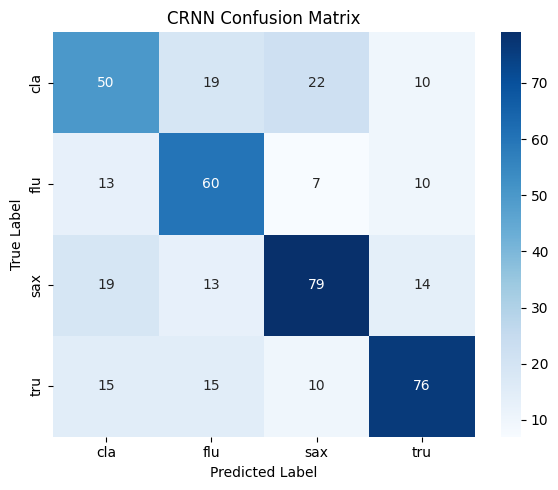

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🔍 Clarinet Confusion Breakdown:
Predicted as cla: 50 times
Predicted as flu: 19 times
Predicted as sax: 22 times
Predicted as tru: 10 times


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

# Get predictions
y_pred_crnn = crnn_model.predict(X_val_mfcc)
y_pred_classes_crnn = np.argmax(y_pred_crnn, axis=1)
y_true_classes_crnn = np.argmax(y_val, axis=1)

# Metrics
accuracy_crnn = np.mean(y_pred_classes_crnn == y_true_classes_crnn)
precision_crnn = precision_score(y_true_classes_crnn, y_pred_classes_crnn, average='macro', zero_division=0)
recall_crnn = recall_score(y_true_classes_crnn, y_pred_classes_crnn, average='macro', zero_division=0)
f1_crnn = f1_score(y_true_classes_crnn, y_pred_classes_crnn, average='macro', zero_division=0)

# Print general metrics
print(f"📌 Validation Accuracy: {accuracy_crnn * 100:.2f}%")
print(f"🔷 Precision (Macro): {precision_crnn:.2f}")
print(f"🔶 Recall (Macro): {recall_crnn:.2f}")
print(f"💗 F1 Score (Macro): {f1_crnn:.2f}\n")

# Classification report
report = classification_report(y_true_classes_crnn, y_pred_classes_crnn, target_names=np.unique(y_labels))
print("📊 Classification Report:")
print(report)

# Save classification report
with open("crnn_classification_report.txt", "w") as f:
    f.write("CRNN Model - Classification Report\n")
    f.write(f"Accuracy: {accuracy_crnn:.4f}\n")
    f.write(f"Precision (Macro): {precision_crnn:.4f}\n")
    f.write(f"Recall (Macro): {recall_crnn:.4f}\n")
    f.write(f"F1 Score (Macro): {f1_crnn:.4f}\n\n")
    f.write(report)
files.download("crnn_classification_report.txt")

# Confusion matrix
cm = confusion_matrix(y_true_classes_crnn, y_pred_classes_crnn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_labels),
            yticklabels=np.unique(y_labels))
plt.title("CRNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("crnn_confusion_matrix.png")
plt.show()
files.download("crnn_confusion_matrix.png")

# --- Clarinet-focused metrics ---
clarinet_index = np.where(np.unique(y_labels) == 'cla')[0][0]
clarinet_row = cm[clarinet_index]

print("\n🔍 Clarinet Confusion Breakdown:")
for i, count in enumerate(clarinet_row):
    print(f"Predicted as {np.unique(y_labels)[i]}: {count} times")

# Binary clarinet vs others
y_true_binary = (y_true_classes_crnn == clarinet_index).astype(int)
y_pred_binary = (y_pred_classes_crnn == clarinet_index).astype(int)

auc = roc_auc_score(y_true_binary, y_pred_binary)
ap = average_precision_score(y_true_binary, y_pred_binary)
false_negatives = (y_true_binary == 1) & (y_pred_binary == 0)
false_positives = (y_true_binary == 0) & (y_pred_binary == 1)

# Save clarinet metrics
with open("crnn_clarinet_metrics.txt", "w") as f:
    f.write("🔍 Clarinet Confusion Breakdown:\n")
    for i, count in enumerate(clarinet_row):
        f.write(f"Predicted as {np.unique(y_labels)[i]}: {count} times\n")
    f.write(f"\n🎯 Clarinet AUC: {auc:.4f}\n")
    f.write(f"📈 Clarinet Average Precision: {ap:.4f}\n")
    f.write(f"\n❌ False Negatives: {np.sum(false_negatives)}\n")
    f.write(f"⚠️ False Positives: {np.sum(false_positives)}\n")
files.download("crnn_clarinet_metrics.txt")


In [ ]:
# Save model to HDF5 format
crnn_model.save("crnn_chroma_model.h5")

from google.colab import files
files.download("crnn_chroma_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>